In [2]:
import pandas as pd
import geopandas
import os
import seaborn as sns
import numpy as np

In [3]:
FETCH_CURRENT = True

if FETCH_CURRENT:
    report_path = "https://www.maine.gov/dep/ftp/hoss/spill_report.txt"
    report_product_found_path = "https://www.maine.gov/dep/ftp/hoss/report_product_found.txt"
    report_inc_medium_path = "https://www.maine.gov/dep/ftp/hoss/report_inc_medium.txt"
else:
    hoss_path = "../maine-data/environmental/HOSS"
    report_path = os.path.join(hoss_path, "spill_report.txt")
    report_product_found_path = os.path.join(hoss_path, "report_product_found.txt")
    report_inc_medium_path = os.path.join(hoss_path, "report_inc_medium.txt")

In [4]:
report_header = ["L.SPILL_NUMBER",
    "CREATE_DATE",
    "CREATE_BY",
    "MODIFY_DATE",
    "MODIFY_BY",
    "REPORT_STATUS",
    "REPORT_STATUS_VALUE",
    "ACTUAL_SPILL_DATETIME",
    "ACTUAL_SPILL_DATE_UNKNOWN_FLAG",
    "ACTUAL_SPILL_TIME_UNKNOWN_FLAG",
    "LOCATION_NAME",
    "LOCATION_DESCRIPTION",
    "LOCATION_TOWN_MCD",
    "LOCATION_TOWN_MCD_VALUE",
    "LOCATION_TOWN_LOCAL_NAME",
    "LOCATION_STATE_PROVINCE",
    "NUMBER_WELLS_AT_RISK",
    "NUMBER_WELLS_IMPACTED",
    "DTREE_COMPLETED_FLAG",
    "DTREE_DATE",
    "DTREE_CODE",
    "DTREE_VALUE",
    "MATERIAL_DISPOSAL_INFO",
    "FURTHER_RESPONSE_ACTION_FLAG",
    "SPILL_TYPE_CODE",
    "SPILL_TYPE_VALUE",
    "REPORTER_TYPE_CODE",
    "REPORTER_TYPE_VALUE",
    "DETECTION_METHOD_CODE",
    "DETECTION_METHOD_VALUE",
    "INC_LOCATION_CODE",
    "INC_LOCATION_VALUE",
    "INC_SOURCE_CODE",
    "INC_SOURCE_VALUE",
    "SPILL_CAUSE_CODE",
    "SPILL_CAUSE_VALUE"]
report_df = pd.read_csv(report_path, header=None, names=report_header, delimiter="*", on_bad_lines='warn', index_col=0)

/tmp/ipykernel_29489/2486885791.py:37: ParserWarning: Skipping line 56678: expected 36 fields, saw 38

  report_df = pd.read_csv(report_path, header=None, names=report_header, delimiter="*", on_bad_lines='warn', index_col=0)
/tmp/ipykernel_29489/2486885791.py:37: DtypeWarning: Columns (19,20,21,26) have mixed types. Specify dtype option on import or set low_memory=False.
  report_df = pd.read_csv(report_path, header=None, names=report_header, delimiter="*", on_bad_lines='warn', index_col=0)


In [5]:
report_medium_header = [
    "L.SPILL_NUMBER",
    "MEDIUM_CODE",
    "MEDIUM_VALUE"]
report_medium_df = pd.read_csv(report_inc_medium_path, header=None, names=report_medium_header, delimiter="*", on_bad_lines='warn', index_col=0)

In [6]:
report_product_found_header = [
    "L.SPILL_NUMBER",
    "PRODUCT_CODE",
    "PRODUCT_CODE_VALUE",
    "PRODUCT_OTHER",
    "PRODUCT_AMOUNT",
    "PRODUCT_AMOUNT_UNIT",
    "PRODUCT_AMOUNT_UNIT_VALUE",
    "PRODUCT_AMOUNT_QUALIFIER",
    "PRIMARY_PRODUCT_FLAG"]
report_product_found_df = pd.read_csv(report_product_found_path, header=None, names=report_product_found_header, delimiter="*", on_bad_lines='warn', index_col=0)

In [7]:
# Convert the 'ACTUAL_SPILL_DATETIME' column to datetime format
report_df['ACTUAL_SPILL_DATETIME'] = pd.to_datetime(report_df['ACTUAL_SPILL_DATETIME'], errors='coerce')
report_df['CREATE_DATE'] = pd.to_datetime(report_df['CREATE_DATE'], errors='coerce')


In [8]:
report_recent_df = report_df[report_df['CREATE_DATE'].dt.year >= 2021]
report_recent_df.shape

(6227, 35)

In [9]:
report_recent_df = report_recent_df.join(report_product_found_df, on='L.SPILL_NUMBER', how='left') \
    .join(report_medium_df, on='L.SPILL_NUMBER', how='left')

In [10]:
# Converts oz. to gals.
report_recent_df['PRODUCT_AMOUNT'] = report_recent_df.apply(
    lambda row: row['PRODUCT_AMOUNT'] * 0.0078125 if row['PRODUCT_AMOUNT_UNIT_VALUE'] == 'oz.' else row['PRODUCT_AMOUNT'], axis=1)
report_recent_df['PRODUCT_AMOUNT_UNIT_VALUE'] = report_recent_df['PRODUCT_AMOUNT_UNIT_VALUE'].replace('oz.', 'gals.')

In [11]:
report_recent_df['PRODUCT_AMOUNT_UNIT_VALUE'].value_counts()

PRODUCT_AMOUNT_UNIT_VALUE
gals.       4181
lbs.          32
cu. yds.       6
tons           2
Name: count, dtype: int64

In [12]:
# Only keep spills with liquid measurement unit
report_recent_df = report_recent_df[report_recent_df['PRODUCT_AMOUNT_UNIT_VALUE'] == 'gals.']

In [13]:
report_recent_df['SPILL_TYPE_VALUE'].value_counts()


SPILL_TYPE_VALUE
Oil Incident                       3879
Hazardous Material Incident         266
Non-Oil, Non-Hazardous Incident      36
Name: count, dtype: int64

In [14]:
# Discard the Non-oil, Non-Hazardous Incident
report_recent_df = report_recent_df[report_recent_df['SPILL_TYPE_VALUE'] != 'Non-Oil, Non-Hazardous Incident']
# Discard spills that had 0 amount
report_recent_df = report_recent_df[report_recent_df['PRODUCT_AMOUNT'] > 0]

In [15]:
report_recent_df.index.value_counts()

L.SPILL_NUMBER
B-161-2023    9
P-196-2023    8
A-775-2024    6
P-203-2021    6
P-882-2020    6
             ..
A-6-2021      1
P-527-2020    1
P-494-2020    1
P-493-2020    1
P-487-2020    1
Name: count, Length: 3136, dtype: int64

In [16]:
# View data for a spill that has multiple rows
report_recent_df.loc[['B-235-2025', 'B-129-2025', 'A-64-2025'], ['PRODUCT_AMOUNT', 'LOCATION_TOWN_LOCAL_NAME', 'PRODUCT_CODE_VALUE', 'PRIMARY_PRODUCT_FLAG']]

PRODUCT_AMOUNT LOCATION_TOWN_LOCAL_NAME  \
L.SPILL_NUMBER                                            
B-235-2025                 2.0         EAST MILLINOCKET   
B-235-2025                 2.0         EAST MILLINOCKET   
B-235-2025                 0.2         EAST MILLINOCKET   
B-235-2025                 0.2         EAST MILLINOCKET   
B-235-2025                 5.0         EAST MILLINOCKET   
B-235-2025                 5.0         EAST MILLINOCKET   
B-129-2025                 1.5                   ORLAND   
B-129-2025                 1.5                   ORLAND   
B-129-2025                 1.8                   ORLAND   
B-129-2025                 1.8                   ORLAND   
A-64-2025                 40.0                  WINDSOR   
A-64-2025                 50.0                  WINDSOR   

                                            PRODUCT_CODE_VALUE  \
L.SPILL_NUMBER                                                   
B-235-2025                                       HYDRAULIC OIL   
B-235-2025                                       HYDRAULIC OIL   
B-235-2025                            WASTE OIL/USED MOTOR OIL   
B-235-2025                            WASTE OIL/USED MOTOR OIL   
B-235-2025                                              DIESEL   
B-235-2025                                              DIESEL   
B-129-2025                            WASTE OIL/USED MOTOR OIL   
B-129-2025                            WASTE OIL/USED MOTOR OIL   
B-129-2025                                         ANTI-FREEZE   
B-129-2025                                         ANTI-FREEZE   
A-64-2025                                 GASOLINE UNSPECIFIED   
A-64-2025       Material Containing PFAS - Specified in Report   

               PRIMARY_PRODUCT_FLAG  
L.SPILL_NUMBER                       
B-235-2025                        F  
B-235-2025                        F  
B-235-2025                        F  
B-235-2025                        F  
B-235-2025                        T  
B-235-2025                        T  
B-129-2025                        F  
B-129-2025                        F  
B-129-2025                        T  
B-129-2025                        T  
A-64-2025                         F  
A-64-2025                         T

L.SPILL_NUMBER LOCATION_TOWN_MCD_VALUE  PRODUCT_AMOUNT
0       P-387-2022                   ACTON            50.0
1       A-625-2022                  ALBION           200.0
2       A-777-2024        ALDER STREAM TWP             1.0
3       P-229-2023                  ALFRED           200.0
4       A-542-2023                    ALNA            20.0
..             ...                     ...             ...
258     P-151-2022               WOODSTOCK           600.0
259     P-553-2023                WOOLWICH           300.0
260     A-121-2025               WYMAN TWP            21.0
261     P-603-2022                YARMOUTH           800.0
262     P-196-2023                    YORK         10040.0

[263 rows x 3 columns]

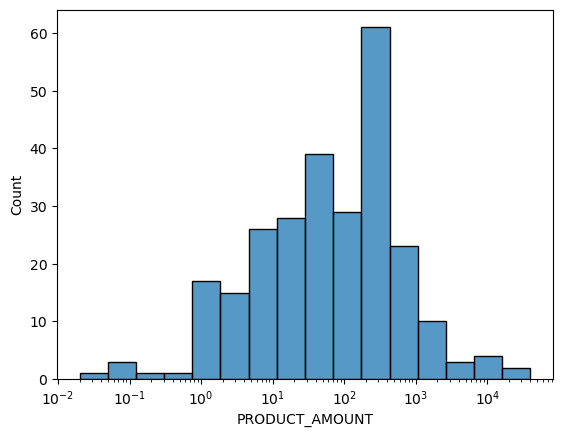

In [17]:
# Calculate total (liquid) amount in each spill
report_town_spill_total = report_recent_df.groupby(['L.SPILL_NUMBER', 'LOCATION_TOWN_MCD_VALUE'])['PRODUCT_AMOUNT'].sum().to_frame().reset_index()
report_town_spill_total['PRODUCT_AMOUNT'] = np.round(report_town_spill_total['PRODUCT_AMOUNT'], 2)
# For each town, get the spill with the largest product amount
idx = report_town_spill_total.groupby('LOCATION_TOWN_MCD_VALUE')['PRODUCT_AMOUNT'].idxmax()
report_town_spill_total = report_town_spill_total.loc[idx].reset_index(drop=True)
sns.histplot(report_town_spill_total, x='PRODUCT_AMOUNT', log_scale=True)
report_town_spill_total

In [18]:
# Subset report_recent_df on spills with largest amount
print("Before shape", report_recent_df.shape)
report_recent_df = report_recent_df.loc[report_town_spill_total['L.SPILL_NUMBER']]
print("After shape", report_recent_df.shape)


Before shape (3998, 45)
After shape (499, 45)


In [19]:
# Create column for comma delimited product code values
report_all_product_vals = report_recent_df.groupby("L.SPILL_NUMBER")['PRODUCT_CODE_VALUE'].unique().apply(lambda x: ',<br> '.join(x))

In [20]:
#create column for comma delimited medium value
report_all_medium_vals = report_recent_df.fillna("").groupby("L.SPILL_NUMBER")['MEDIUM_VALUE'].unique().apply(lambda x: ',<br> '.join(x))

In [21]:
report_mapped_df = report_town_spill_total.merge(report_all_product_vals, on='L.SPILL_NUMBER').merge(report_all_medium_vals, on='L.SPILL_NUMBER')
report_mapped_df = report_mapped_df.merge(report_df[['LOCATION_DESCRIPTION', 'CREATE_DATE']], on="L.SPILL_NUMBER")
report_mapped_df = report_mapped_df.fillna("")
report_mapped_df

L.SPILL_NUMBER LOCATION_TOWN_MCD_VALUE  PRODUCT_AMOUNT  \
0       P-387-2022                   ACTON            50.0   
1       A-625-2022                  ALBION           200.0   
2       A-777-2024        ALDER STREAM TWP             1.0   
3       P-229-2023                  ALFRED           200.0   
4       A-542-2023                    ALNA            20.0   
..             ...                     ...             ...   
258     P-151-2022               WOODSTOCK           600.0   
259     P-553-2023                WOOLWICH           300.0   
260     A-121-2025               WYMAN TWP            21.0   
261     P-603-2022                YARMOUTH           800.0   
262     P-196-2023                    YORK         10040.0   

                                    PRODUCT_CODE_VALUE  \
0                                               DIESEL   
1                                          #2 FUEL OIL   
2                                               DIESEL   
3                               #1 FUEL OIL - KEROSENE   
4                                      TRANSFORMER OIL   
..                                                 ...   
258                             #1 FUEL OIL - KEROSENE   
259                                        #2 FUEL OIL   
260                                    TRANSFORMER OIL   
261                                        #6 FUEL OIL   
262  Material Containing PFAS - Specified in Report...   

                                          MEDIUM_VALUE  \
0                                                 Land   
1             Interior Surface,<br> Indoor Air Quality   
2                                                 Land   
3                                Land,<br> Groundwater   
4                 Outdoor Impervious Surface,<br> Land   
..                                                 ...   
258  Land,<br> Indoor Air Quality,<br> Groundwater,...   
259      Land,<br> Indoor Air Quality,<br> Groundwater   
260                                               Land   
261  Coastal Water,<br> Inland Surface Water,<br> L...   
262  Engineered Containment,<br> Groundwater,<br> L...   

           LOCATION_DESCRIPTION CREATE_DATE  
0                    532 H ROAD  2022-08-04  
1                261 MARKS ROAD  2022-11-23  
2                     RT. 27 NB  2024-12-04  
3             28 FEDERAL STREET  2023-04-20  
4                 399 BAILEY RD  2023-09-17  
..                          ...         ...  
258           83 LAKESIDE DRIVE  2022-04-13  
259  716 MOUNTAIN ROAD WOOLWICH  2023-08-07  
260              30 CALON DRIVE  2025-03-08  
261          677 COUSINS STREET  2022-10-26  
262                   SPUR ROAD  2023-04-02  

[263 rows x 7 columns]

In [24]:
# Plot info on largest spill in each town in the last 5 years
# Include info on products involved in spill and effected material(s)
gdf = geopandas.read_file("../maine-data/geo/geojson_maine_towns.json")
gdf.head()

OBJECTID           TOWN                              GlobalID  \
0         1     Frenchboro  ee8bb63d-54d4-455e-9948-d40898324057   
1         2          Abbot  0047b8de-4caf-4abe-8782-edbcdca48245   
2         3          Acton  cc6bccdf-4ecc-4170-8dd0-1eb0396da924   
3         4  Adamstown Twp  5d1fb48e-0374-48d8-a41d-1c83ef53da1c   
4         5        Addison  aa0b064c-af0b-457d-8a64-2dc29ff10202   

                   created_user                     created_date  \
0  Emily.Pettit@maine.gov_maine 2024-02-27 23:11:49.298000+00:00   
1  Emily.Pettit@maine.gov_maine 2024-02-27 23:11:49.298000+00:00   
2  Emily.Pettit@maine.gov_maine 2024-02-27 23:11:49.298000+00:00   
3  Emily.Pettit@maine.gov_maine 2024-02-27 23:11:49.298000+00:00   
4  Emily.Pettit@maine.gov_maine 2024-02-27 23:11:49.298000+00:00   

               last_edited_user                 last_edited_date  \
0  Emily.Pettit@maine.gov_maine 2024-02-27 23:11:49.298000+00:00   
1  Emily.Pettit@maine.gov_maine 2024-02-27 23:11:49.298000+00:00   
2  Emily.Pettit@maine.gov_maine 2024-02-27 23:11:49.298000+00:00   
3  Emily.Pettit@maine.gov_maine 2024-02-27 23:11:49.298000+00:00   
4  Emily.Pettit@maine.gov_maine 2024-02-27 23:11:49.298000+00:00   

    Shape__Area  Shape__Length  \
0  3.064595e+04    1410.535089   
1  9.238878e+07   38485.033723   
2  1.064538e+08   53561.995004   
3  1.000542e+08   40046.363605   
4  2.600747e+08   79762.959465   

                                            geometry  
0  MULTIPOLYGON (((-67.09989 44.50026, -67.10004 ...  
1  POLYGON ((-69.40209 45.16091, -69.40416 45.160...  
2  POLYGON ((-70.90845 43.5976, -70.90702 43.5941...  
3  POLYGON ((-70.80454 44.92494, -70.81043 44.924...  
4  POLYGON ((-67.6644 44.64325, -67.66435 44.6432...

In [25]:
# Capitalize town names
gdf['TOWN'] = gdf['TOWN'].str.upper()
gdf = gdf[['TOWN', 'geometry']]

In [26]:
# Check if any town names in our report aren't in geojson data
set(report_mapped_df['LOCATION_TOWN_MCD_VALUE'].tolist()) - set(gdf['TOWN'].tolist())

set()

In [27]:
# Set Maine location coordinate system
gdf = gdf.to_crs(epsg=3463)

In [28]:
spill_gdf = gdf.merge(report_mapped_df, left_on='TOWN', right_on='LOCATION_TOWN_MCD_VALUE')
spill_gdf = spill_gdf.to_crs(gdf.crs)
spill_gdf['PRODUCT_AMOUNT']
def apply_title_if_string(value):
    if isinstance(value, str):
        return value.title() if value != "NA" and value != "ME" else value
    return value
spill_gdf = spill_gdf.map(apply_title_if_string)

In [39]:
fields = ['L.SPILL_NUMBER', 'TOWN', 'LOCATION_DESCRIPTION', 'PRODUCT_AMOUNT', 'PRODUCT_CODE_VALUE', 'MEDIUM_VALUE', 'CREATE_DATE']
# fields=['L.SPILL_NUMBER']
aliases = ['Spill Number', 'Town', 'Location', 'Amount Spilled (gals.)', 'Products Spilled', 'Medium Affected', 'Date']
m = spill_gdf.explore(column="PRODUCT_AMOUNT",
                  scheme="Percentiles",  # use mapclassify's natural breaks scheme
                  legend=True,  # show legend
                  k=5,  # Bins
                  cmap='plasma',
                  tooltip=fields,
                  tooltip_kwds=dict(
                    aliases=aliases,
                    localize=True # Adds commas to numbers
                  ),
                  style_kwds=dict(
                      fillOpacity=0.7,
                      weight=1
                  ),
                  legend_kwds=dict(
                      caption='Largest spill in past 5 years (gals.)',
                      fmt="{0:,.1f}",
                      colorbar=False,
                      interval=True
                  ),
                  control_scale=False,
                  attr='© OpenStreetMap contributors | Spill data from <a href="https://www.maine.gov/dep/hoss/">https://www.maine.gov/dep/hoss/</a>'
                  )
m.save("./out/hoss.html")
m